blog post: https://eng.uber.com/coordconv/
paper: https://arxiv.org/abs/1807.03247

In [1]:
from matplotlib import rcParams, animation, rc
from ipywidgets import interact, interactive, fixed
from ipywidgets.widgets import *
from torch import nn
from torch.nn.init import kaiming_normal_ as kaimining_normal
from fastai.conv_learner import *
rc('animation', html='html5')
rcParams['figure.figsize'] = 3, 3

# Functions

In [2]:
def get_preds(dataset, idx, learn, scale=False):
#     import ipdb; ipdb.set_trace()
    if type(idx) == int:
        inputs = np.expand_dims(dataset[idx],0)
        model_output = np.exp(learn.predict_array(inputs))
        model_output = model_output/model_output.sum()
        model_output = model_output.reshape(-1,64,64)
        model_output = np.tile(model_output, (3,1,1))
        model_output = np.transpose(model_output, [1,2,0])
        if scale:
            model_output = (model_output-model_output.min())/(model_output.max() - model_output.min())
            
    elif type(idx) == list:
        inputs = dataset[idx]
        model_output = np.exp(learn.predict_array(inputs))
        model_output = model_output.T/model_output.sum(axis=1)
        model_output = model_output.T
        model_output = model_output.reshape(len(idx),-1,64,64)
        model_output = np.tile(model_output, (1,3,1,1))
#         print(model_output.shape)
        model_output = np.transpose(model_output, [2,3,1,0])
#         print(model_output.shape)
        if scale:
            model_output = (model_output - model_output.min(axis=(0,1,2,)))/(model_output.max(axis=(0,1,2,)) - model_output.min(axis=(0,1,2,)))
        model_output = np.transpose(model_output, [3,0,1,2])
#         print(model_output.shape)
    return model_output

def check_pred_vs_actual(ys, dataset, idx, preds, chsn=None):
    if not chsn:
        if type(idx) == list:
            chsn = np.random.choice(np.arange(len(idx)))
            
        elif type(idx) == int:
            chsn = idx
#             preds = preds[None]
    actual = dataset[idx][chsn]
#     print(idx, chsn)
    if actual.shape[0] > 3:
        actual = actual[:3]
    print('model predicted {0}'.format(dind_to_ij[np.argmax(preds[chsn][:,:,0])]))
    print('actual coords are {0}'.format(dind_to_ij[ys[idx][chsn]]))
    fig, ax = plt.subplots(nrows=1, ncols=2,figsize=(10,5))
    ax[0].imshow(preds[chsn])
    ax[0].title.set_text('Predicted')
    ax[1].imshow(np.transpose(actual, (1,2,0)))
    ax[1].title.set_text('Actual')
    return chsn#, actual

# make dataset

In [3]:
# dims are batch_size, height, width
data = np.zeros(((64)**2, 64, 64, 3))
y = []
dind_to_ij = {}
for b in np.arange(data.shape[0]):
    i = b//64
    j = b%64
    data[b,i,j,:] = 1
    y.append(b)
    dind_to_ij[b] = (j, i)
y = np.array(y)
shuffle_idx = np.arange(len(data))
np.random.shuffle(shuffle_idx)

# reindex data and y
data = data[shuffle_idx]
y = y[shuffle_idx]

In [4]:
# the y-class should be filled rows first and incrementing columns after e.g. class 0 = (0,1), 1 = (0,2), 64 = (1,1) etc.
def get_row_col(idx):
    return dind_to_ij[y[idx]]
get_row_col(0)

(21, 13)

(5, 52)


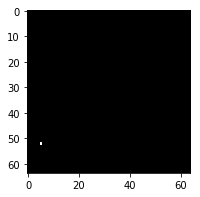

In [5]:
idx = 1
print(get_row_col(idx))
plt.imshow(data[idx])

In [6]:
fig, ax = plt.subplots(figsize=(5,5))
plt.close()
def animate(i):
    ax.imshow(data[i])
    ax.title.set_text('coords: {0}'.format(get_row_col(i)))
#     if dind_to_ij[i] == (0,0):
#         print(i)
# show first 30 frames of data    
ani = animation.FuncAnimation(fig, animate, frames = np.arange(0,30), interval = 5000)
ani

853 (21, 13)


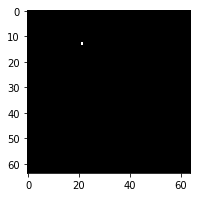

In [7]:
print(y[0], dind_to_ij[y[0]])
plt.imshow(data[0])

# make uniform set and quandrant set

In [8]:
def get_trn_val_idx(data, dtype='uniform'):
    if dtype=='uniform':
        trn_idx = np.random.choice(np.arange(data.shape[1]**2), size = int(data.shape[0]*.75),replace=False)
        val_idx = np.array([idx for idx in np.arange(data.shape[0]) if idx not in trn_idx])
    elif dtype=='quadrant':
        trn_idx = []
        val_idx = []
        h = data[0].shape[0]
        w = data[0].shape[1]
        # first quadrant is val, rest is trn
        for i in np.arange(data.shape[0]):
            if data[i][:int(h/2), :int(w/2), :].sum() > 0:
                val_idx.append(i)
            else:
                trn_idx.append(i)
        trn_idx = np.array(trn_idx)
        val_idx = np.array(val_idx)
    else:
        raise ValueError('dtype must be "uniform" or "quadrant"')
    return trn_idx, val_idx

In [9]:
uni_idxs = get_trn_val_idx(data)
quad_idxs = get_trn_val_idx(data, dtype='quadrant')

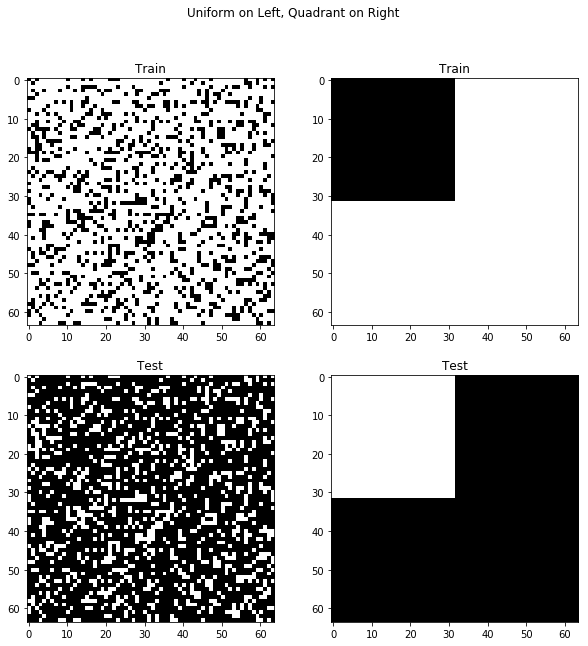

In [10]:
fig, ax = plt.subplots(2, 2, figsize=(10,10))
fig.suptitle('Uniform on Left, Quadrant on Right')
plt.close()
ax[0,0].imshow(data[uni_idxs[0]].sum(axis=0))
ax[0,0].title.set_text('Train')
ax[1,0].imshow(data[uni_idxs[1]].sum(axis=0))
ax[1,0].title.set_text('Test')
ax[0,1].imshow(data[quad_idxs[0]].sum(axis=0))
ax[0,1].title.set_text('Train')
ax[1,1].imshow(data[quad_idxs[1]].sum(axis=0))
ax[1,1].title.set_text('Test')
fig

# make model classes for fastai training

In [11]:
class Conv(nn.Module):
    def __init__(self, ic, oc, ks=3, drop=0.0, bn=True, act=None):
        super().__init__()
        self.conv = nn.Conv2d(ic, oc, ks, padding=(ks-1)//2)
        self.bn = nn.BatchNorm2d(oc, momentum=0.05) if bn else None
        self.drop = nn.Dropout(drop)
        self.act = nn.ReLU(True)
        kaiming_normal(self.conv.weight.data)
        
    def forward(self, x):
        x = self.conv(x)
        if self.bn: x = self.bn(x)
        if not self.act:
            return self.drop(x)
        else:
            return self.drop(self.act(x))

In [12]:
# swap axes for pytorch as they need (bs, C, H, W)
data = np.transpose(data,axes=(0,3,1,2))

In [13]:
ttype = quad_idxs
X_train = data[ttype[0]]
y_train = y[ttype[0]]
X_val = data[ttype[1]]
y_val = y[ttype[1]]

In [14]:
trn = tuple([X_train, y_train])
val = tuple([X_val, y_val])
path='data/'
imdata = ImageClassifierData.from_arrays(path, trn, val, bs=32, classes = y, test = trn)

In [15]:
class AddCoords(nn.Module):
    def __init__(self, x_dim=64, y_dim=64, with_r=False):
            super(AddCoords, self).__init__()
            self.x_dim = x_dim
            self.y_dim = y_dim
            self.with_r = with_r
            
    def forward(self, input_tensor):
        batch_size = input_tensor.size()[0]
        x_coord = torch.range(start=0,end=self.x_dim-1).unsqueeze(-1)
        x_coord = x_coord.repeat((1,self.y_dim)).expand(batch_size,-1,-1)
        y_coord = torch.transpose(torch.range(start=0,end=self.y_dim-1).unsqueeze(-1), 0, 1)
        y_coord = y_coord.repeat((self.x_dim,1)).expand(batch_size,-1,-1)
        x_channel = (x_coord/(self.x_dim-1))*2-1
        y_channel = (y_coord/(self.y_dim-1))*2-1
        x_channel = x_channel.unsqueeze(1)
        y_channel = y_channel.unsqueeze(1)
        try:
            ret = torch.cat([input_tensor, x_channel, y_channel], dim=1)
        except:
            ret = torch.cat([input_tensor, x_channel.cuda(), y_channel.cuda()], dim=1)
        return ret            

In [16]:
cnet = nn.Sequential(
    AddCoords(),
    nn.Conv2d(5, 32, kernel_size=1, padding=0),
    nn.BatchNorm2d(32),
    nn.ReLU(),

    nn.Conv2d(32, 32, kernel_size=1, padding=0),
    nn.BatchNorm2d(32),        
    nn.ReLU(),
    
    nn.Conv2d(32, 64, kernel_size=1, padding=0),
    nn.BatchNorm2d(64),        
    nn.ReLU(),
    
    nn.Conv2d(64, 64, kernel_size=1, padding=0),
    nn.BatchNorm2d(64),        
    nn.ReLU(),
    
    nn.Conv2d(64, 1, kernel_size=1, padding=0),
    nn.BatchNorm2d(1),        
    nn.ReLU(),
    
    Flatten(),
    nn.Linear(4096, len(y))
)

In [17]:
for chld in cnet.children():
    if isinstance(chld,nn.Conv2d):
        kaiming_normal(chld.weight.data)

In [18]:
# epochs = 100
# cnet.cuda()
# loss = nn.CrossEntropyLoss()
# tot_losses = []
# optimizer = optim.SGD(cnet.parameters(), lr=0.001)
# for i in tqdm(range(epochs)):
#     tot_loss = 0
#     for mb in iter(imdata.trn_dl):
#         inputs, targets = mb
#         preds = cnet(inputs)
#         optimizer.zero_grad()
#         current_loss = loss(preds, targets)
# #         print(current_loss)
#         tot_loss += to_np(current_loss)
#         current_loss.backward()
#         optimizer.step()
#     tot_losses.append(tot_loss)

In [19]:
# tot_losses

In [20]:
cbm = BasicModel(cnet.cuda(), name='cconvnet')
clearn = ConvLearner(imdata, cbm)
clearn.crit = nn.CrossEntropyLoss()
# learn.opt_fn = optim.Adam(learn.model.parameters())
clearn.unfreeze()
clearn.metrics=[accuracy]

epoch      trn_loss   val_loss   accuracy                 
    0      8.334787   8.455269   0.0       



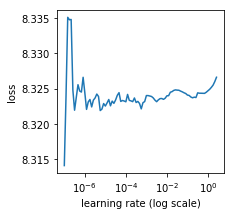

In [21]:
start_lr = 1e-7
wds = 1e-5
clearn.lr_find(start_lr = start_lr, wds = wds)
clearn.sched.plot(n_skip=0)

In [27]:
wds = 1e-5
lr = 1e-3
clearn.fit(lr, 8, wds=wds, cycle_len=3 )#use_clr=(32,10)
# learn.fit(lr, 2, wds=wds, cycle_len=10, )

epoch      trn_loss   val_loss   accuracy                 
    0      8.261424   9.319408   0.0       
    1      8.216399   9.470264   0.0                      
    2      8.144118   9.509211   0.0                      
    3      8.263047   9.449538   0.0                      
    4      8.198619   9.574042   0.0                      
 24%|██▍       | 23/96 [00:00<00:01, 48.15it/s, loss=8.15]

/home/justin/anaconda3/envs/fastai/lib/python3.6/site-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


    5      8.118946   9.640501   0.0                      
    6      8.217378   9.13097    0.0                      
    7      8.10191    9.440589   0.0                      
    8      7.941479   9.555786   0.0                      
    9      7.865352   9.464386   0.0                      
    10     6.850172   9.964334   0.0                      
    11     5.771236   10.081162  0.0                      
    12     4.836462   10.613794  0.0                      
    13     2.253037   10.744596  0.0                      
    14     0.766658   10.765628  0.0                       
    15     0.304136   10.486523  0.0                       
    16     0.053481   10.564304  0.0                        
    17     0.015535   10.564575  0.0                        
    18     0.009119   10.583836  0.0                         
    19     0.00679    10.592126  0.0                         
    20     0.00587    10.602457  0.0                         
    21     0.005423   10.622782  0.0     

[10.632947862148285, 0.0]

model predicted (56, 38)
actual coords are (56, 38)


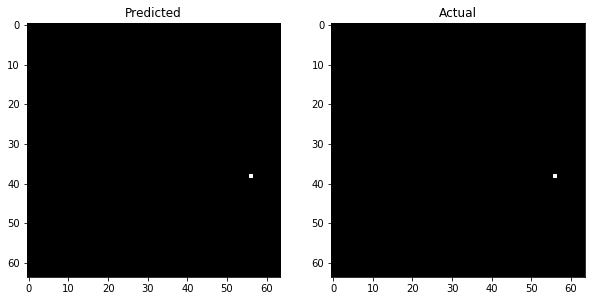

In [28]:
# dataset, ys = X_val, y_val
dataset, ys = X_train, y_train
idx = list(np.random.choice(range(len(dataset)), 10))
preds = get_preds(dataset, idx, clearn, scale=True)
chsn = check_pred_vs_actual(ys, dataset, idx, preds)

# regular conv

In [14]:
net = nn.Sequential(
    Conv(3, 64),
    Conv(64, 64, drop=.1),
    Conv(64, 64, drop=.05),
    nn.MaxPool2d(2),
#     Conv(128, 128),
    Conv(64, 64, drop=.05),
    nn.MaxPool2d(2),
#     Conv(64, 64, ks=1),
#     Conv(128, 64, ks=1),
    nn.MaxPool2d(2),
    Flatten(),
    nn.Linear(1024, len(y))
)

In [15]:
bm = BasicModel(net.cuda(), name='convnet')
learn = ConvLearner(imdata, bm)
learn.crit = nn.CrossEntropyLoss()
# learn.opt_fn = optim.Adam(learn.model.parameters())
learn.unfreeze()
learn.metrics=[accuracy]

epoch      trn_loss   val_loss   accuracy                    
    0      8.707044   10.149744  0.0       



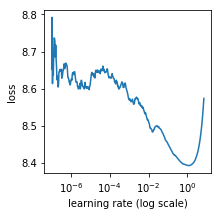

In [55]:
start_lr = 1e-7
wds = 1e-5
learn.lr_find(start_lr = start_lr, wds = wds)
learn.sched.plot(n_skip=0)

In [56]:
lr = 1e-2
learn.fit(lr, 5, wds=wds, cycle_len=5, )#use_clr=(32,10)
# learn.fit(lr, 2, wds=wds, cycle_len=10, )

epoch      trn_loss   val_loss   accuracy                    
    0      8.331408   8.324324   0.0       
    1      8.173329   8.40664    0.0                         
    2      6.982401   8.614412   0.0                         
  3%|▎         | 13/384 [00:00<00:04, 85.34it/s, loss=6.16] 

/home/justin/anaconda3/envs/fastai/lib/python3.6/site-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


    3      4.958818   9.297387   0.0                         
    4      3.158472   10.27405   0.0                         
    5      6.048515   8.725919   0.000977                    
    6      4.141955   9.219611   0.0                         
    7      2.362541   10.566793  0.0                         
    8      0.819157   13.144396  0.0                          
    9      0.244428   14.042649  0.0                          
    10     2.85182    9.49828    0.0                         
    11     1.814062   10.570581  0.0                         
    12     0.669473   12.754532  0.0                          
    13     0.187498   14.216559  0.0                          
    14     0.09348    14.357657  0.0                           
    15     0.93871    11.567408  0.0                          
    16     0.81594    11.989625  0.0                          
    17     0.329176   13.171421  0.0                          
    18     0.104832   14.280336  0.0                         

[14.819224767386913, 0.0]

model predicted (32, 3)
actual coords are (31, 3)


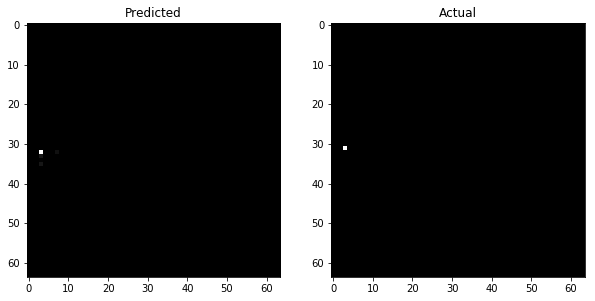

In [60]:
dataset, ys = X_val, y_val
# dataset, ys = X_train, y_train
idx = list(np.random.choice(range(len(dataset)), 10))
preds = get_preds(dataset, idx, learn, scale=True)
chsn = check_pred_vs_actual(ys, dataset, idx, preds)

# CoordConv

## making the adding of channels happen in an actual layer

In [17]:
class AddCoords(nn.Module):
    def __init__(self, x_dim=64, y_dim=64, with_r=False):
            super(AddCoords, self).__init__()
            self.x_dim = x_dim
            self.y_dim = y_dim
            self.with_r = with_r
            
    def forward(self, input_tensor):
        batch_size = input_tensor.size()[0]
        x_coord = torch.range(start=0,end=self.x_dim-1).unsqueeze(-1)
        x_coord = x_coord.repeat((1,self.y_dim)).expand(batch_size,-1,-1)
        y_coord = torch.transpose(torch.range(start=0,end=self.y_dim-1).unsqueeze(-1), 0, 1)
        y_coord = y_coord.repeat((self.x_dim,1)).expand(batch_size,-1,-1)
        x_channel = (x_coord/(self.x_dim-1))*2-1
        y_channel = (y_coord/(self.y_dim-1))*2-1
        x_channel = x_channel.unsqueeze(1)
        y_channel = y_channel.unsqueeze(1)
        try:
            ret = torch.cat([input_tensor, x_channel, y_channel], dim=1)
        except:
            ret = torch.cat([input_tensor, x_channel.cuda(), y_channel.cuda()], dim=1)
        return ret
    
class CoordConv(nn.Module):
    def __init__(self, ic, oc, ks=3, drop=0.0, bn=True, act=None):
        super().__init__()
        self.addcoords = AddCoords()
        self.conv = nn.Conv2d(ic, oc, ks, padding=(ks-1)//2)
        self.bn = nn.BatchNorm2d(oc, momentum=0.05) if bn else None
        self.drop = nn.Dropout(drop)
        self.act = nn.ReLU(True)
        kaiming_normal(self.conv.weight.data)
        
    def forward(self, x):
        x = self.addcoords(x)
        x = self.conv(x)
        if self.bn: x = self.bn(x)
        if not self.act:
            return self.drop(x)
        else:
            return self.drop(self.act(x))   

In [76]:
cnet = nn.Sequential(
    AddCoords(),
    nn.Conv2d(5,32,3, padding=1),
    nn.ReLU(),
    nn.BatchNorm2d(32),
    nn.Conv2d(32,64,3, padding=1),
    nn.ReLU(),
    nn.BatchNorm2d(64),
    nn.Conv2d(64,4,3, padding=1),
    nn.ReLU(),
    nn.BatchNorm2d(4),
    nn.Conv2d(4,2,1, padding=0),
    nn.ReLU(),
    nn.BatchNorm2d(2),
    Flatten(),
    nn.Linear(8192, len(y))
)

In [72]:
cbm = BasicModel(cnet.cuda(), name='cconvnet')
clearn = ConvLearner(imdata, cbm)
clearn.crit = nn.CrossEntropyLoss()
# learn.opt_fn = optim.Adam(learn.model.parameters())
clearn.unfreeze()
clearn.metrics=[accuracy]

 27%|██▋       | 103/384 [00:01<00:03, 79.57it/s, loss=8.32]

/home/justin/anaconda3/envs/fastai/lib/python3.6/site-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


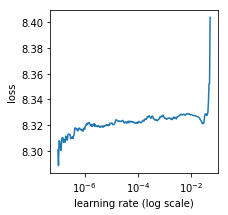

In [73]:
start_lr = 1e-7
wds = 1e-5
clearn.lr_find(start_lr = start_lr, wds = wds)
clearn.sched.plot(n_skip=0)

In [75]:
lr = 1e-2
clearn.fit(lr, 5, wds=wds, cycle_len=5, )#use_clr=(32,10)
# learn.fit(lr, 2, wds=wds, cycle_len=10, )

/home/justin/anaconda3/envs/fastai/lib/python3.6/site-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


epoch      trn_loss   val_loss   accuracy   
    0      8.326593   8.327491   0.0       
    1      8.348373   8.367668   0.0                        
    2      8.335207   8.375347   0.0                        
    3      8.32544    8.349344   0.0                        
    4      8.310258   8.343943   0.0                        
    5      8.360151   8.539106   0.0                        
    6      8.403439   8.486798   0.0                        
    7      8.354891   8.451192   0.0                        
    8      8.321377   8.370584   0.0                        
    9      8.297553   8.38274    0.0                        
    10     8.383646   8.392712   0.0                        
    11     8.392326   8.628762   0.0                        
    12     8.3949     8.385317   0.0                        
    13     8.336523   8.390004   0.0                        
    14     8.297467   8.385499   0.0                        
    15     8.420815   8.461858   0.0                     

[8.421966888010502, 0.0]

model predicted (30, 53)
actual coords are (5, 19)


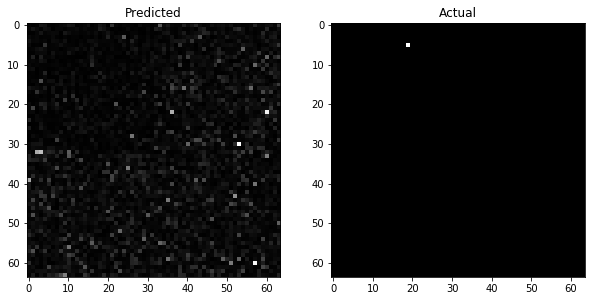

In [44]:
dataset, ys = X_val, y_val
# dataset, ys = X_train, y_train
idx = list(np.random.choice(range(len(dataset)), 10))
preds = get_preds(dataset, idx, clearn, scale=True)
chsn = check_pred_vs_actual(ys, dataset, idx, preds)

## just concating two channels two data

In [81]:
ichan = np.array([[i]*64 for i in range(64)])
# ichan = np.array([[i/64]*64 for i in range(64)])
# ichan = ichan/ichan.sum()
# ichan = np.array([[1]*64 for i in range(64)])
# !!! paper does linear scaling to values being between [-1, 1]. All my commented stuff above didn't work so maybe linear scaling is the key
ichan = (ichan - ichan.mean())/ichan.mean()
jchan = ichan.T
ichan = ichan.reshape(-1,1,64,64)
jchan = jchan.reshape(-1,1,64,64)
ichan = np.tile(ichan,(4096,1,1,1))
jchan = np.tile(jchan,(4096,1,1,1))
ccdata = np.append(data, ichan, axis=1)
ccdata = np.append(ccdata, jchan, axis=1)
print(ccdata.shape)

(4096, 5, 64, 64)


In [88]:
ttype = uni_idxs
cX_train = ccdata[ttype[0]]
cy_train = y[ttype[0]]
cX_val = ccdata[ttype[1]]
cy_val = y[ttype[1]]

In [89]:
ctrn = tuple([cX_train, cy_train])
cval = tuple([cX_val, cy_val])
path='data/'
cimdata = ImageClassifierData.from_arrays(path, ctrn, cval, bs=8, classes = y, test = ctrn)

In [90]:
# cnet = nn.Sequential(
#     CoordConvTh(x_dim=64, y_dim=64,in_channels=5, out_channels=64, kernel_size=3,with_r =False),
#     Conv(64, 128,),
#     Conv(128, 128),
#     nn.MaxPool2d(2),
#     Conv(128, 128),
#     Conv(128, 128),
#     nn.MaxPool2d(2),
#     Conv(128, 128),
#     Conv(128, 128),
#     nn.MaxPool2d(2),
#     Conv(128, 128, ks=1),
#     Conv(128, 128, ks=1),
#     nn.MaxPool2d(2),
#     Flatten(),
#     nn.Linear(1152, len(y))
# )
cnet = nn.Sequential(
    Conv(5, 64),
    Conv(64, 64),
#     Conv(64, 64),
    nn.MaxPool2d(2),
    Conv(64, 64),
    nn.MaxPool2d(2),
#     Conv(128, 128),
    Conv(64, 64),
    nn.MaxPool2d(2),
#     Conv(64, 64, ks=1),
#     Conv(128, 64, ks=1),
    nn.MaxPool2d(2),
    Flatten(),
    nn.Linear(1024, len(y))
)

/home/justin/anaconda3/envs/fastai/lib/python3.6/site-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


# manual train version, not using fastai learn

In [77]:
epochs = 100
cnet.cuda()
loss = nn.CrossEntropyLoss()
tot_losses = []
optimizer = optim.SGD(cnet.parameters(), lr=0.01)
for i in tqdm(range(epochs)):
    tot_loss = 0
    for mb in iter(imdata.trn_dl):
        inputs, targets = mb
        preds = cnet(inputs)
        optimizer.zero_grad()
        current_loss = loss(preds, targets)
#         print(current_loss)
        tot_loss += to_np(current_loss)
        current_loss.backward()
        optimizer.step()
    tot_losses.append(tot_loss)

  0%|          | 0/100 [00:00<?, ?it/s]

/home/justin/anaconda3/envs/fastai/lib/python3.6/site-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


100%|██████████| 100/100 [04:56<00:00,  2.96s/it]


In [78]:
tot_losses

[3194.591185569763,
 3194.2317209243774,
 3194.254101753235,
 3193.858090400696,
 3193.48561668396,
 3193.709979057312,
 3193.05530834198,
 3192.63148021698,
 3191.1970071792603,
 3188.612668991089,
 3186.4704265594482,
 3183.708444595337,
 3180.0879430770874,
 3176.709038734436,
 3173.206708908081,
 3169.832341194153,
 3166.7717666625977,
 3163.8229007720947,
 3161.1887702941895,
 3158.6182222366333,
 3156.61571598053,
 3154.598550796509,
 3152.872685432434,
 3150.9936838150024,
 3149.335696220398,
 3148.0233640670776,
 3146.7245473861694,
 3145.343321800232,
 3143.9438304901123,
 3143.028172492981,
 3142.017604827881,
 3141.0318126678467,
 3139.953450202942,
 3138.963936805725,
 3138.4289331436157,
 3137.494222640991,
 3136.5351028442383,
 3135.8701553344727,
 3124.998035430908,
 2656.6076040267944,
 216.02396273612976,
 5.757376134395599,
 0.3584163188934326,
 0.17906033992767334,
 0.15114235877990723,
 0.13157641887664795,
 0.11962676048278809,
 0.10877716541290283,
 0.100252389907

/home/justin/anaconda3/envs/fastai/lib/python3.6/site-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


# fastai train

In [91]:
# bm = BasicModel(cnet.cuda(), name='cconvnet')
# learn = ConvLearner(cimdata, bm)
# learn.crit = nn.CrossEntropyLoss()
# # learn.opt_fn = optim.Adam
# learn.unfreeze()
# learn.metrics=[accuracy]
# lr = 1e-3
# wds = 1e-5
cbm = BasicModel(cnet.cuda(), name='cconvnet')
clearn = ConvLearner(cimdata, cbm)
clearn.crit = nn.CrossEntropyLoss()
# learn.opt_fn = optim.Adam(learn.model.parameters())
clearn.unfreeze()
clearn.metrics=[accuracy]

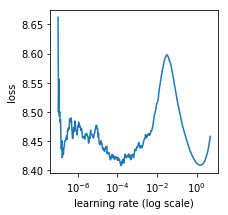

In [92]:
start_lr = 1e-7
wds = 1e-3
clearn.lr_find(start_lr = start_lr, wds = wds)
clearn.sched.plot(n_skip=0)

In [93]:
lr = 1e-3
clearn.fit(lr, 5, wds=wds, cycle_len=5, )

epoch      trn_loss   val_loss   accuracy                    
    0      8.529655   8.545803   0.0       
 65%|██████▌   | 251/384 [00:01<00:01, 130.81it/s, loss=8.41]

/home/justin/anaconda3/envs/fastai/lib/python3.6/site-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


    1      8.439579   8.657943   0.0                         
    2      8.343199   8.728895   0.0                         
    3      8.269825   8.775618   0.0                         
    4      8.219871   8.785853   0.0                         
    5      8.401781   8.865913   0.0                         
    6      8.29965    9.033655   0.0                         
    7      8.018324   9.240879   0.0                         
    8      7.478297   9.376225   0.0                         
    9      7.150596   9.403051   0.0                         
    10     7.549452   9.703269   0.0                         
    11     6.315166   10.471535  0.0                         
    12     5.227128   11.229546  0.0                         
    13     4.26264    11.725202  0.0                         
    14     3.665722   11.962707  0.0                         
    15     5.092035   11.630415  0.0                         
    16     4.051677   12.511661  0.0                         
    17  

[17.225726075470448, 0.0]

In [80]:
# for manual
cbm = BasicModel(cnet, name='cconvnet')
clearn = ConvLearner(imdata, cbm)

model predicted (23, 63)
actual coords are (21, 22)


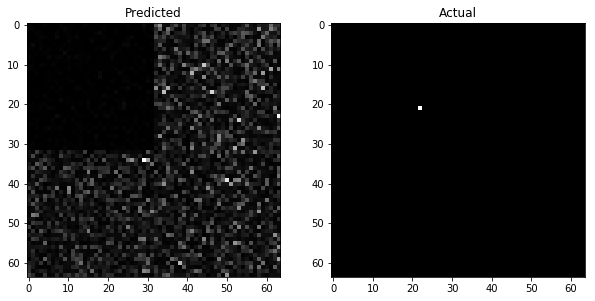

/home/justin/anaconda3/envs/fastai/lib/python3.6/site-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


In [95]:
dataset, ys = X_val, y_val
# dataset, ys = X_train, y_train
idx = list(np.random.choice(range(len(dataset)), 10))
preds = get_preds(dataset, idx, clearn, scale=True)
chsn = check_pred_vs_actual(ys, dataset, idx, preds)

# stuff from 
https://github.com/mkocabas/CoordConv-pytorch/blob/master/CoordConv-numpy.py

In [98]:
class AddCoordsNp():
    """Add coords to a tensor"""
    def __init__(self, x_dim=64, y_dim=64, with_r=False):
        self.x_dim = x_dim
        self.y_dim = y_dim
        self.with_r = with_r

    def call(self, input_tensor):
        """
        input_tensor: (batch, x_dim, y_dim, c)
        """
        batch_size_tensor = np.shape(input_tensor)[0]

        xx_ones = np.ones([1, self.x_dim], dtype=np.int32)
        xx_ones = np.expand_dims(xx_ones, -1)

        print(xx_ones.shape)

        xx_range = np.expand_dims(np.arange(self.x_dim), 0)
        xx_range = np.expand_dims(xx_range, 1)

        print(xx_range.shape)

        xx_channel = np.matmul(xx_ones, xx_range)
        xx_channel = np.expand_dims(xx_channel, -1)

        yy_ones = np.ones([1, self.y_dim], dtype=np.int32)
        yy_ones = np.expand_dims(yy_ones, 1)

        print(yy_ones.shape)

        yy_range = np.expand_dims(np.arange(self.y_dim), 0)
        yy_range = np.expand_dims(yy_range, -1)

        print(yy_range.shape)

        yy_channel = np.matmul(yy_range, yy_ones)
        yy_channel = np.expand_dims(yy_channel, -1)

        xx_channel = xx_channel.astype('float32') / (self.x_dim - 1)
        yy_channel = yy_channel.astype('float32') / (self.y_dim - 1)

        xx_channel = xx_channel*2 - 1
        yy_channel = yy_channel*2 - 1

        xx_channel = xx_channel.repeat(batch_size_tensor, axis=0)
        yy_channel = yy_channel.repeat(batch_size_tensor, axis=0)

        ret = np.concatenate([input_tensor, xx_channel, yy_channel], axis=-1)

        if self.with_r:
            rr = np.sqrt( np.square(xx_channel-0.5) + np.square(yy_channel-0.5))
            ret = np.concatenate([ret, rr], axis=-1)

        return ret
    
class AddCoordsTh(nn.Module):
    def __init__(self, x_dim=64, y_dim=64, with_r=False):
        super(AddCoordsTh, self).__init__()
        self.x_dim = x_dim
        self.y_dim = y_dim
        self.with_r = with_r

    def forward(self, input_tensor):
        """
        input_tensor: (batch, c, x_dim, y_dim)
        """
        batch_size_tensor = input_tensor.shape[0]

        xx_ones = torch.ones([1, self.y_dim], dtype=torch.int32)
        xx_ones = xx_ones.unsqueeze(-1)

        xx_range = torch.arange(self.x_dim, dtype=torch.int32).unsqueeze(0)
        xx_range = xx_range.unsqueeze(1)

        xx_channel = torch.matmul(xx_ones, xx_range)
        xx_channel = xx_channel.unsqueeze(-1)

        yy_ones = torch.ones([1, self.x_dim], dtype=torch.int32)
        yy_ones = yy_ones.unsqueeze(1)

        yy_range = torch.arange(self.y_dim, dtype=torch.int32).unsqueeze(0)
        yy_range = yy_range.unsqueeze(-1)

        yy_channel = torch.matmul(yy_range, yy_ones)
        yy_channel = yy_channel.unsqueeze(-1)

        xx_channel = xx_channel.permute(0, 3, 2, 1)
        yy_channel = yy_channel.permute(0, 3, 2, 1)

        xx_channel = xx_channel.float() / (self.x_dim - 1)
        yy_channel = yy_channel.float() / (self.y_dim - 1)

        xx_channel = xx_channel * 2 - 1
        yy_channel = yy_channel * 2 - 1

        xx_channel = xx_channel.repeat(batch_size_tensor, 1, 1, 1)
        yy_channel = yy_channel.repeat(batch_size_tensor, 1, 1, 1)

        try:
            ret = torch.cat([input_tensor, xx_channel, yy_channel], dim=1)
        except:
            ret = torch.cat([input_tensor, xx_channel.cuda(), yy_channel.cuda()], dim=1)

        if self.with_r:
            rr = torch.sqrt(torch.pow(xx_channel - 0.5, 2) + torch.pow(yy_channel - 0.5, 2))
            ret = torch.cat([ret, rr], dim=1)

        return ret


class CoordConvTh(nn.Module):
    """CoordConv layer as in the paper."""
    def __init__(self, x_dim, y_dim, with_r, *args, **kwargs):
        super(CoordConvTh, self).__init__()
        self.addcoords = AddCoordsTh(x_dim=x_dim, y_dim=y_dim, with_r=with_r)
        self.conv = nn.Conv2d(*args, **kwargs)

    def forward(self, input_tensor):
        ret = self.addcoords(input_tensor)
        ret = self.conv(ret)
        return ret    

In [99]:
tnet = nn.Sequential(
    CoordConvTh(64,64,False, 5, 64,3, padding=1),
    Conv(64, 64),
#     Conv(64, 64),
    nn.MaxPool2d(2),
    Conv(64, 64),
    nn.MaxPool2d(2),
#     Conv(128, 128),
    Conv(64, 64),
    nn.MaxPool2d(2),
#     Conv(64, 64, ks=1),
#     Conv(128, 64, ks=1),
    nn.MaxPool2d(2),
    Flatten(),
    nn.Linear(1024, len(y))
)
tnet.cuda()

Sequential(
  (0): CoordConvTh(
    (addcoords): AddCoordsTh()
    (conv): Conv2d(5, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (1): Conv(
    (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn): BatchNorm2d(64, eps=1e-05, momentum=0.05, affine=True, track_running_stats=True)
    (drop): Dropout(p=0.0)
    (act): ReLU(inplace)
  )
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv(
    (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn): BatchNorm2d(64, eps=1e-05, momentum=0.05, affine=True, track_running_stats=True)
    (drop): Dropout(p=0.0)
    (act): ReLU(inplace)
  )
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv(
    (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn): BatchNorm2d(64, eps=1e-05, momentum=0.05, affine=True, track_running_stats=True)
    (drop): Dropout(p=0.0)
    (ac

In [100]:
ttrn = tuple([X_train, y_train])
tval = tuple([X_val, y_val])
path='data/'
timdata = ImageClassifierData.from_arrays(path, ttrn, tval, bs=8, classes = y, test = ttrn)

In [101]:
tbm = BasicModel(tnet.cuda(), name='cconvnet')
tlearn = ConvLearner(timdata, tbm)
tlearn.crit = nn.CrossEntropyLoss()
# learn.opt_fn = optim.Adam(learn.model.parameters())
tlearn.unfreeze()
tlearn.metrics=[accuracy]

/home/justin/anaconda3/envs/fastai/lib/python3.6/site-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


epoch      trn_loss   val_loss   accuracy   
    0      17.867516  4430333396.0 0.0       


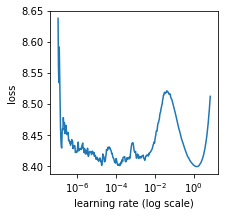

In [102]:
start_lr = 1e-7
wds = 1e-3
tlearn.lr_find(start_lr = start_lr, wds = wds)
tlearn.sched.plot(n_skip=0)

In [103]:
lr = 1e-3
tlearn.fit(lr, 5, wds=wds, cycle_len=5, )

epoch      trn_loss   val_loss   accuracy                    
    0      8.49467    8.509831   0.0       
 90%|████████▉ | 345/384 [00:03<00:00, 105.36it/s, loss=8.42]

/home/justin/anaconda3/envs/fastai/lib/python3.6/site-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


    1      8.425457   8.616431   0.0                         
    2      8.34841    8.68122    0.0                         
    3      8.280203   8.717347   0.0                         
    4      8.235326   8.724276   0.0                         
    5      8.392513   8.804944   0.0                         
    6      8.34277    8.909337   0.0                         
    7      8.280219   8.985424   0.0                         
    8      8.222332   9.033882   0.0                         
    9      8.17476    9.044699   0.0                         
    10     8.358302   9.058197   0.0                         
    11     8.304188   9.15201    0.0                         
    12     8.246058   9.31115    0.0                         
    13     8.159673   9.395216   0.0                         
    14     8.064775   9.452968   0.0                         
    15     8.31437    9.386372   0.0                         
    16     7.959654   9.611783   0.0                         
    17  

[12.988775178790092, 0.0]

In [104]:
tlearn.fit(lr, 5, wds=wds, cycle_len=5, )

epoch      trn_loss   val_loss   accuracy                    
    0      4.491286   11.656829  0.0       
    1      4.082848   11.925264  0.0                         
 12%|█▎        | 48/384 [00:00<00:03, 105.69it/s, loss=3.05]

/home/justin/anaconda3/envs/fastai/lib/python3.6/site-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


    2      3.129779   13.238707  0.0                         
    3      2.213499   14.354283  0.0                         
    4      1.619522   14.606708  0.0                         
    5      3.433766   12.626601  0.0                         
    6      2.61071    13.816467  0.0                         
    7      1.657536   15.405205  0.0                         
    8      0.871992   16.405121  0.0                          
    9      0.577089   16.82894   0.0                          
    10     2.0073     15.336714  0.0                          
    11     1.53825    16.050221  0.0                         
    12     0.732954   17.494535  0.0                          
    13     0.331792   18.351046  0.0                          
    14     0.214814   18.475483  0.0                          
    15     0.776019   18.087893  0.0                          
    16     0.71109    18.656214  0.0                          
    17     0.359982   18.9532    0.0                          

[20.720709547400475, 0.0]

model predicted (3, 46)
actual coords are (2, 46)


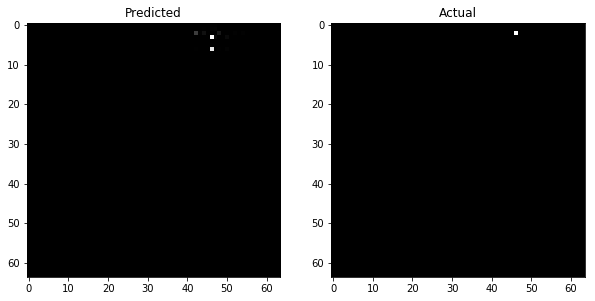

/home/justin/anaconda3/envs/fastai/lib/python3.6/site-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


In [110]:
dataset, ys = X_val, y_val
# dataset, ys = X_train, y_train
idx = list(np.random.choice(range(len(dataset)), 10))
preds = get_preds(dataset, idx, tlearn, scale=True)
chsn = check_pred_vs_actual(ys, dataset, idx, preds)

# https://blog.piekniewski.info/2018/07/14/autopsy-dl-paper/

In [239]:
import scipy.signal as sp
import numpy as np
# Fix some image dimensions
I_width = 100
I_height = 70

In [245]:
# Generate input image
A=np.zeros((I_height,I_width))
# Generate random test position
pos_x = np.random.randint(0, I_width-1)
pos_y = np.random.randint(0, I_height-1)
# Put a pixel in a random test position
A[pos_y, pos_x]=1

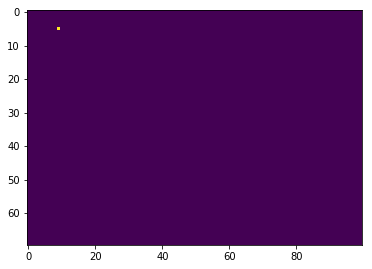

In [248]:
plt.figure(figsize=(6,8))
plt.imshow(A)

In [278]:
print('point(is at ({0}, {1})'.format(pos_x, pos_y))

# Create what will be the coordinate features
X=np.zeros_like(A)
Y=np.zeros_like(A)
# Fill the X-coordinate value
for x in range(I_width):
    X[:,x] = x
# Fill the Y-coordinate value
for y in range(I_height):
    Y[y,:] = y
# Define the convolutional operators
op1 = np.array([[0, 0, 0],
                [0, -1, 0],
                [0, 0, 0]])

opx = np.array([[0, 0, 0],
                [0, I_width, 0],
                [0, 0, 0]])

opy = np.array([[0, 0, 0],
                [0, I_height, 0],
                [0, 0, 0]])    
# Convolve to get the first feature map DY
CA0 = sp.convolve2d(A, opy, mode='same')
CY0 = sp.convolve2d(Y, op1, mode='same')
DY=CA0+CY0
# Convolve to get the second feature map DX
CA1 = sp.convolve2d(A, opx, mode='same')
CX0 = sp.convolve2d(X, op1, mode='same')
DX=CA1+CX0
# Apply half rectifying nonlinearity
DX[np.where(DX<0)]=0
DY[np.where(DY<0)]=0
# Subtract from a constant (extra layer with a bias unit)
result_y=I_height-DY.sum()
result_x=I_width-DX.sum()
# Check the result
assert(pos_x == int(result_x))
assert(pos_y == int(result_y))
print(result_x)
print(result_y)

point(is at (9, 5)
9.0
5.0


In [280]:
CA1

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

# stuff to delete?

In [ ]:
# class TrainAccuracy(Callback):
#     def __init__(self):
#         pass
#     def on_epoch_end(self, metrics):
#         import ipdb; ipdb.set_trace()

# callbacks=[TrainAccuracy()]